# Predicting the Helpfulness of Amazon Reviews
### Keane Johnson and Tucker Anderson

This notebook builds a model that predicts the helpfulness of Amazon reviews. It uses the [2015 Amazon Review dataset](http://jmcauley.ucsd.edu/data/amazon/index.html), compiled by Julian McAuley, associate professor in the Computer Science department at the University of California, San Diego.

The dataset contains product reviews from Amazon from May 1996 - July 2014, and includes ratings, text, helpfulness votes, descriptions, category information, price, brand, and image features. It is broken into smaller subsets, organized by product category.

This notebook focuses on the Home and Kitchen sub-category, and uses the aforementioned features to predict helpfulness.

## Outline
- Import Libraries
- Load and Prepare Dataset
- Exploratory Data Analysis
- Baseline Model (Naive Bayes)
- Neural Net Models

## Import Libraries

In [1]:
# load packages
import gzip
import json
import os
import wget

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Load and Prepare Dataset

In [2]:
# load dataset - download directly from source, save to data directory

file_name = "data/reviews_Home_and_Kitchen_5.json.gz"
output_dir = "data"
url = "http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Home_and_Kitchen_5.json.gz"

if not os.path.isdir(output_dir):
    os.makedirs(output_dir)

if not os.path.isfile(file_name):
    file_name = wget.download(url, out=output_dir)

In [3]:
# helper functions to parse data from compressed json into pandas DF
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def get_dataframe(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')


# helper function to pull out total helpful votes
def get_helpful_votes(helpful):
    [helpful, total] = helpful
    return helpful


# helper function to pull out total votes (helpful and unhelpful)
def get_total_votes(helpful):
    [helpful, total] = helpful
    return total
    
    
# helper function to calculate helpfulness percentage 
def calculate_helpful_perc(helpful):
    [helpful, total] = helpful
    if total == 0:
        return 0
    else:
        return (helpful/total)

In [4]:
# create dataframe
df = get_dataframe(file_name)

# parse helpful column into new columns of helpful_votes, total_votes, helpful_perc
df['helpful_votes'] = df['helpful'].apply(get_helpful_votes)
df['total_votes'] = df['helpful'].apply(get_total_votes)
df['helpful_perc'] = df['helpful'].apply(calculate_helpful_perc)

## Exploratory Data Analysis

### Data Insights

In [5]:
df.shape

(551682, 12)

The dataset contains 551,682 rows and twelve columns.

In [6]:
df.sample(5)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,helpful_votes,total_votes,helpful_perc
282392,AVLCKO0ZI8AG,B001PMHQGS,"Carebear ""Jamie""","[0, 0]",i bought a cheap one from walmart and it was l...,5.0,best one yet,1376784000,"08 18, 2013",0,0,0.000000
201723,ASI1TUIINGNSV,B000RH173A,Chelsie Hess,"[0, 0]",These seem pretty low quality for what I was h...,3.0,Does the job... kinda,1361232000,"02 19, 2013",0,0,0.000000
477756,A36IHC0K68NS2,B007NE7PKY,"Jeffrey N. Fritz ""Nikon Jeff""","[8, 11]",The Pinzon Signature 190-Gram Velvet Flannel D...,5.0,Change Your Bedding And Change Your Bedroom,1345075200,"08 16, 2012",8,11,0.727273
347966,A3QZ6XASE7BWZO,B0037NZ5ES,Chef Mommy,"[0, 0]",Best of everything. Plastic utensils melt (ev...,5.0,Bamboo fan,1374624000,"07 24, 2013",0,0,0.000000
143987,A3GGDAIEUHRNUG,B000F8EUFI,V. Natarajan,"[0, 0]",I have to echo the other reviewers that this t...,5.0,Powerhouse vac,1332806400,"03 27, 2012",0,0,0.000000


The twelve columns contain data including the reviewer name and review time, in addition to more applicable data to our models, like review text, summary, and helpful scores. The helpful column is a list of two numbers. The first number is the number of individuals who found that review helpful. The second number is the total number of individuals who scored that review.

We parse out these two numbers in helpful_votes and total_votes. We calculate the helpfulness percentage as well in helpful_perc. This is simply the number of helpful_votes divided by the number of total_votes. Helpful_perc will be our target variable in our models.

There are two sources of natural language in the dataset - reviewText and summary. We assume the reviewText will be more robust and impactful in determining whether a review is helpful or not. However, summary is a good resource for our models as well.

Next, we want to examine the completeness of our dataset.

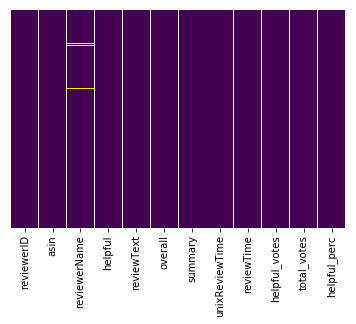

In [7]:
sns.heatmap(df.isnull(),cbar=False,yticklabels=False,cmap = 'viridis')

This heatmap shows that there are missing values for some observations of reviewerName. However, with such a large dataset, we could be missing some values for other features that just do not appear on this chart

In [8]:
missing_df = pd.DataFrame(df.isnull().sum())
missing_df

,0
reviewerID,0
asin,0
reviewerName,4953
helpful,0
reviewText,0
overall,0
summary,0
unixReviewTime,0
reviewTime,0
helpful_votes,0


We confirm that we are only missing values for reviewerName. We reason that this does not have an impact on our analysis because we will be using primarily the reviewText, and possibly the summary, to determine a review's helpfulness. Additionally, we argue that individuals do not consistently use a reviewer's name when determining a review's helpfulness.

### Summary Statistics

After reviewing some sample data, and examining missing values, we next look at some summary statistics of our dataset.

In [9]:
df.describe()

,overall,unixReviewTime,helpful_votes,total_votes,helpful_perc
count,551682.000000,5.516820e+05,551682.000000,551682.000000,551682.000000
mean,4.316655,1.348687e+09,3.497348,3.939469,0.367910
std,1.110749,6.120238e+07,76.539142,77.801556,0.456931
min,1.000000,9.572256e+08,0.000000,0.000000,0.000000
25%,4.000000,1.331770e+09,0.000000,0.000000,0.000000
50%,5.000000,1.367626e+09,0.000000,0.000000,0.000000
75%,5.000000,1.388880e+09,1.000000,2.000000,1.000000
max,5.000000,1.406074e+09,52176.000000,52861.000000,1.000000


These summary statistics show that over half of our observations have a 0% helpfulness. In addition, these observations have zero total votes. This means that the reviews simply haven't been voted upon. We should remove these observations from our dataset because our model could misinterpret the 0% helpful_perc to mean that the review was not helpful when in fact the review just hasn't been voted upon.

### Examining the Target Variable

We can use a histogram to visualize the distribution of helpful percentages.

Text(0.5,1,'Histogram of Helpful Percentages')

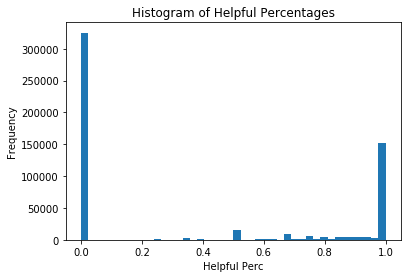

In [10]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(1, 1, 1)
n, bins, patches = ax1.hist(x=df['helpful_perc'], bins='auto')
                                 
ax1.set_xlabel('Helpful Perc')
ax1.set_ylabel('Frequency')
ax1.set_title('Histogram of Helpful Percentages')

This histogram shows that the majority of reviews have a 0% helpful percentage, with the second most prevalent percentage being 100%. However, our dataset needs to be cleaned to remove observations where there are no total votes.

### Data Cleaning

We want to drop rows where there are no total votes whatsoever, to prevent our model from interpreting these reviews as being unhelpful.

In [11]:
df = df[df.total_votes != 0]
df.shape

(248634, 12)

The size of our dataset is now 248,634 rows. Still robust enough to use for our models. Next we can examine the new distribution of helpful_perc.

In [12]:
df.describe()

,overall,unixReviewTime,helpful_votes,total_votes,helpful_perc
count,248634.000000,2.486340e+05,248634.000000,248634.000000,248634.000000
mean,4.108529,1.323709e+09,7.760097,8.741097,0.816338
std,1.273446,7.365012e+07,113.866220,115.710631,0.311763
min,1.000000,9.572256e+08,0.000000,1.000000,0.000000
25%,4.000000,1.293667e+09,1.000000,1.000000,0.750000
50%,5.000000,1.349827e+09,2.000000,2.000000,1.000000
75%,5.000000,1.376611e+09,4.000000,5.000000,1.000000
max,5.000000,1.405987e+09,52176.000000,52861.000000,1.000000


The median helpful_perc is 100%. We could be at risk of not having a good distribution of data to train on. This could result in our model being overly optimistic and inflating the helpfulness scores of reviews. We can visualize this skew with another histogram.

Text(0.5,1,'Histogram of Helpful Percentages')

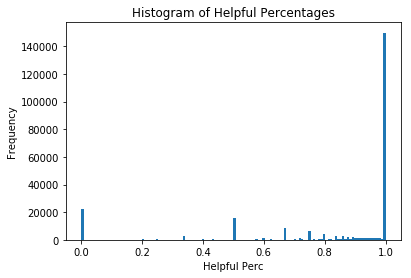

In [13]:
fig2 = plt.figure()
ax2 = fig2.add_subplot(1, 1, 1)
n, bins, patches = ax2.hist(x=df['helpful_perc'], bins='auto')
                                 
ax2.set_xlabel('Helpful Perc')
ax2.set_ylabel('Frequency')
ax2.set_title('Histogram of Helpful Percentages')

## Baseline Model (Naive Bayes Bag of Words with Binary Helpfullness Labels)

### Data Pre-Processing

In [14]:
import nltk
# this nltk download may be needed
# nltk.download()

In [15]:
#ensure there are no missing values in the review or summary text or the overall helpullness percentage
len(df) == len(df.dropna(subset=['reviewText', 'summary', 'helpful_perc']))

True

For our bag of words model, we will combine the reviewText and summary text fields to combine into a single "document" with which to analyze.

In [175]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords 

stop_words = set(stopwords.words('english'))

def tokenize(text):
    return [word for word in word_tokenize(text) if not word in stop_words]

In [176]:
#We should then tokenize and stem the review data before ingesting into our NLP models
df['combinedText'] = df['summary'].str.lower() + ". " +  df['reviewText'].str.lower()
#Now tokenize these and remove stop words
df['processedText'] = df['combinedText'].apply(tokenize)

For the purposes of this model, we will assume a helpfullness percentage of greater than 75% to be "helpful". We can look into this assumptive threshold later on.

In [177]:
df["isHelpful"] = df["helpful_perc"] > .75
df["isHelpful"] = df["isHelpful"].apply(int)

In [178]:
#let's make sure everything looks ok
df.sample(5)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,helpful_votes,total_votes,helpful_perc,combinedText,isHelpful,processedText
411404,A3252UYFVNFRY8,B004MKY64A,N. Booth,"[1, 1]",Nice to be able to pull the hot casserole clos...,5.0,Works Well,1354233600,"11 30, 2012",1,1,1.0,works well. nice to be able to pull the hot ca...,1,"[works, well, ., nice, able, pull, hot, casser..."
173831,A1583BM5TZRMMM,B000KIHMNA,nenan57,"[9, 9]",If you are looking for a Paper Towel Holder th...,2.0,Very flimsey,1291852800,"12 9, 2010",9,9,1.0,very flimsey. if you are looking for a paper t...,1,"[flimsey, ., looking, paper, towel, holder, st..."
289151,A3OPUMECXP3ESC,B001UI37N8,L. Sommers,"[6, 6]",This mill does an excellent job. It grinds fin...,5.0,"Nice, but the best feature is customer service",1342742400,"07 20, 2012",6,6,1.0,"nice, but the best feature is customer service...",1,"[nice, ,, best, feature, customer, service, .,..."
23232,AENXJM2CKEN5L,B000050AQ5,"Joe Zika ""Khemprof""","[2, 2]",Honeywell 17000 Permanent Pure HEPA QuietAir P...,5.0,Honeywell 17000 Permanent Pure HEPA QuietAir A...,1264982400,"02 1, 2010",2,2,1.0,honeywell 17000 permanent pure hepa quietair a...,1,"[honeywell, 17000, permanent, pure, hepa, quie..."
189421,A2HQ1YC01KZE3X,B000OEJMZ6,loriloo,"[1, 1]",These are great! this is the second set I have...,5.0,no slip!,1364083200,"03 24, 2013",1,1,1.0,no slip!. these are great! this is the second ...,1,"[slip, !, ., great, !, second, set, ordered, ...."


In [183]:
from sklearn.feature_extraction.text import TfidfVectorizer

Train_X, Test_X, Train_Y, Test_Y = train_test_split(df['combinedText'],df['isHelpful'],test_size=0.2)

Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(df['combinedText'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

In [188]:
#and train our classifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score

g_classifier = GaussianNB().fit(Train_X_Tfidf.toarray(), Train_Y)
#m_classifier = MultinomialNB().fit(Train_X_Tfidf.toarray, Train_Y)

print("Naive Bayes Accuracy Score -> ", accuracy_score(g_classifier, Test_Y)*100)

ValueError: setting an array element with a sequence.